<img src="https://github.com/danielscarvalho/data/blob/master/img/FIAP-logo.png?raw=True" style="float:right;" width="200px">

# DATA SCIENCE & STATISTICAL COMPUTING [》](https://www.fiap.com.br/)

## FIAP - Engenharia de Software

### Global Solution (GS) 2 - 2024 - 2 Semestre

### Projeto GS de análise de dados

GS 2

Tarefa no MS Teams: **Global Solution 2024 - Data Science - Pegada de Carbono - Análise de dados com AI e ML Scikit-learn**

Escopo: Analisar a **pegada de carbono** ([carbon footprint](https://en.wikipedia.org/wiki/Carbon_footprint)) das nações:<br>

  - Brasil
  - Comparar Brasil com:
    - Global
    - Continente Americano
    - OCDE
    - EUA

### Brasil

É importante observar que o Brasil tem uma base energética renovavel como a hidrelétrica, mas podemos sim desenvolver tecnologia sustentável. E que o Brasil é inovador em energia como biodisel, energia eólica, ethanol, etc...

- Quais são os pontos fortes do Brasil quanto a pegada de carbono?
- Onde o Brasil pode avançar para reduzir a pegada de carbono?

Este tipo de pergunta deve ser respondida com **DADOS**.

### Referências

- Pandas - https://pandas.pydata.org/docs/
- Jupyter - https://docs.jupyter.org/en/latest/
- Seaborn - https://seaborn.pydata.org/
- NumPy - https://numpy.org/
- SciPy - https://scipy.org/
- Scikit-learn - https://scikit-learn.org/stable/ (ML, AI)
- Estatística - https://www.statlearning.com/
- Data Science - https://jakevdp.github.io/PythonDataScienceHandbook/
- Matplotlib - https://matplotlib.org/
- HoloViews - https://holoviews.org/
- Python - https://penseallen.github.io/PensePython2e/
- Python Fluente - https://pythonfluente.com/
- Git - https://git-scm.com/doc
- Kaggle - https://www.kaggle.com/


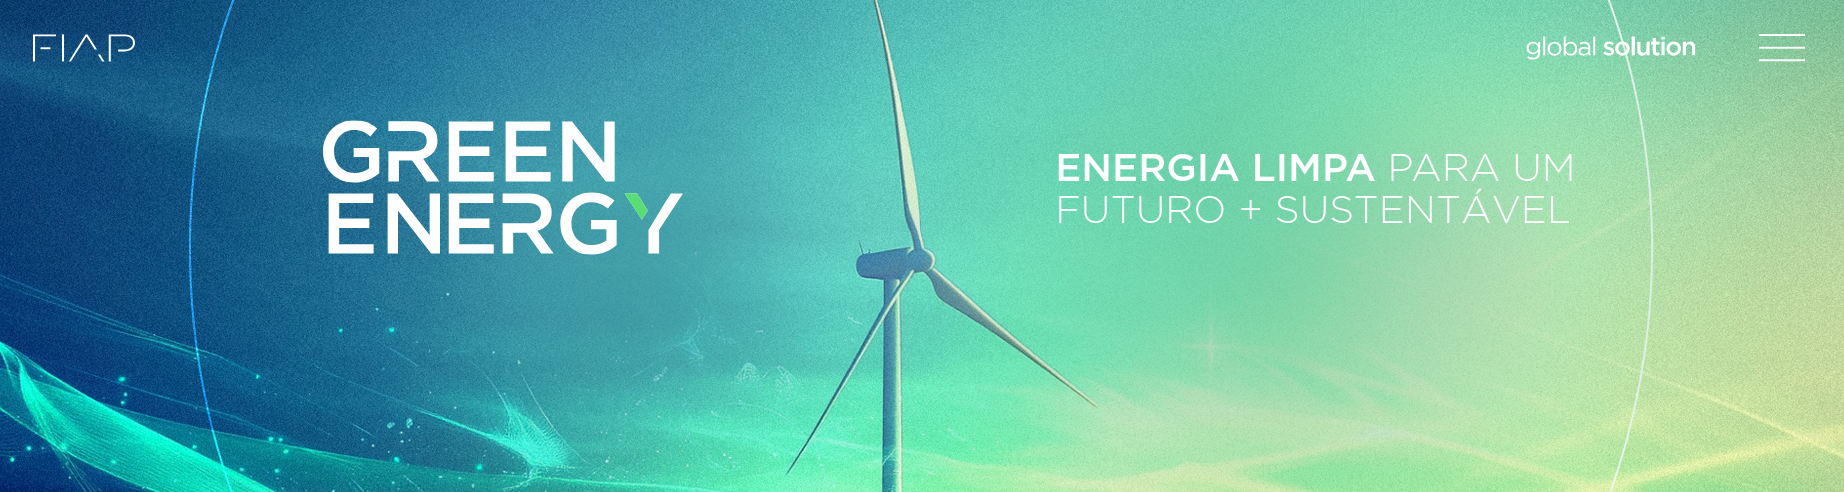

### Ideias de Perguntas

1. ~~Como o Brasil se posiciona em relação às emissões totais de gases de efeito estufa (GEE) em comparação ao total global?~~

2. Qual é a tendência das emissões de CO2 no Brasil nos últimos 20 anos?

3. ~~Quais setores (energia, transporte, agricultura, etc.) contribuem mais para a pegada de carbono do Brasil e como isso difere dos outros países?~~

4. Qual é a participação das fontes de energia renovável no Brasil em comparação com os países da OCDE?

5. Qual é a correlação entre PIB per capita e emissões de CO2 per capita no Brasil e em países da OCDE?

6. Como o Brasil se compara a outros países em termos de intensidade de carbono (emissões por unidade de PIB)?

7. Quais países, entre o Brasil, EUA e o continente americano, mostram maior redução relativa de emissões nos últimos anos?

8. Existe alguma relação entre a proporção de áreas florestais e as emissões líquidas de CO2 entre os países analisados?

9. Como o consumo de energia renovável impacta as emissões totais de GEE no Brasil e globalmente?

10. Como as emissões per capita no Brasil se comparam às dos EUA, da OCDE e do continente americano?

11. Como as políticas públicas voltadas para a redução de emissões no Brasil se refletem em mudanças no setor de energia em comparação aos países da OCDE?

12. Quais países apresentam a maior variação percentual nas emissões de gases de efeito estufa ao longo das últimas décadas, e como o Brasil se posiciona nessa análise?

## Perguntas

### Desenvolvedores:
- Lucas Moreno  - RM 97158
- Julia Ortiz   - RM 550204
- Juliana Maita - RM 99224

### 0. Importando e Tratando

In [1]:
import json
import os
from typing import List, cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns


- Definindo uma função para baixar e cachear os Datasets de https://carbonmonitor.org/

In [2]:
def baixar_carbonmonitor_com_cache(url, cache_file, *args, **kwargs):
    # Tentar ler uma resposta cacheada primeiro
    if os.path.exists(cache_file):
        with open(cache_file, "r") as file:
            print(f"Procurando resposta cacheada no arquivo '{cache_file}'...")
            data = json.load(file)

        # Checando se a resposta cacheada está dentro do período de cache
        idade_resposta = pd.Timestamp.now() - pd.to_datetime(data["__request_date"])
        if idade_resposta < pd.Timedelta(days=1):
            # Cache válido.
            print("Resposta cacheda encontrada.")
            return data["datas"]
        else:
            # Cache inválido.
            # Remover o arquivo antigo de cache, e deixar o resto da função baixar nova resposta...
            print("Resposta cacheada velha demais. Descartando...")
            os.remove(cache_file)

    # Se o cache não estava presente, ou se era inválido...
    print("Baixando dados da API...")
    response = requests.get(url, headers={
        "Host": "datas.carbonmonitor.org",
        "Origin": "https://carbonmonitor.org",
        "Referer": "https://carbonmonitor.org/",
    }, *args, **kwargs)

    # Dar um erro se a resposta do servidor foi inválida
    response.raise_for_status()
    data = response.json()

    # Salvando timestamp atual no arquivo da resposta
    data["__request_date"] = pd.Timestamp.now().isoformat()

    # Salvando a resposta para o arquivo
    with open(cache_file, "w") as file:
        json.dump(data, file)
    print(f"Resposta cacheada no arquivo '{cache_file}'.")
    
    return data["datas"]

#### dfDailyEmissionsPerSector
- Baixando e tratando o Dataset de Emissões de CO2 do Carbonmonitor

In [3]:
# URL do GET request
url = "https://datas.carbonmonitor.org/API/carbon_global/WORLD;China;United%20States;India;EU27%20&%20UK;United%20Kingdom;France;Germany;Italy;Spain;Russia;Japan;Brazil;ROW"

# Caminho do arquivo de cache
cache_file = "carbon_data_cache.json"

# Baixar dados
carbon_data = baixar_carbonmonitor_com_cache(url, cache_file)

# Criando dataframe com os dados importados
dfDailyEmissionsPerSector = (
    pd.DataFrame(carbon_data, columns=["Country", "Date", "Sector", "MtCO2", "Timestamp"])

    # Descartando a coluna Timestamp pois não será necessária
    .drop(columns="Timestamp")

    # Convertendo as colunas Date e MtCO2 para Datetime e Float
    .assign(
        Date = lambda df: pd.to_datetime(df["Date"], format="%d/%m/%Y"),
        MtCO2 = lambda df: pd.to_numeric(df["MtCO2"]) 
        )
    )

# Limpando variáveis
del url, cache_file, carbon_data

dfDailyEmissionsPerSector

Procurando resposta cacheada no arquivo 'carbon_data_cache.json'...
Resposta cacheda encontrada.


Country       Date                  Sector      MtCO2
0       Brazil 2019-01-01       Domestic Aviation   0.023750
1       Brazil 2019-01-01        Ground Transport   0.201663
2       Brazil 2019-01-01                Industry   0.240156
3       Brazil 2019-01-01  International Aviation   0.018398
4       Brazil 2019-01-01                   Power   0.107727
...        ...        ...                     ...        ...
176395   WORLD 2024-09-30        Ground Transport  19.475600
176396   WORLD 2024-09-30                Industry  30.013200
176397   WORLD 2024-09-30  International Aviation   1.831910
176398   WORLD 2024-09-30                   Power  36.848200
176399   WORLD 2024-09-30             Residential   6.363760

[176400 rows x 4 columns]

#### dfDailyEmissionsAggregate
Fazendo um dataframe secundário para segurar os valores agregados entre todos os Setores

In [4]:
dfDailyEmissionsAggregate = dfDailyEmissionsPerSector.groupby(["Country", "Date"])["MtCO2"].sum().reset_index()
dfDailyEmissionsAggregate

Country       Date      MtCO2
0      Brazil 2019-01-01   0.690146
1      Brazil 2019-01-02   0.903277
2      Brazil 2019-01-03   0.966163
3      Brazil 2019-01-04   0.951562
4      Brazil 2019-01-05   0.905974
...       ...        ...        ...
29395   WORLD 2024-09-26  98.824990
29396   WORLD 2024-09-27  96.379110
29397   WORLD 2024-09-28  93.193950
29398   WORLD 2024-09-29  89.392350
29399   WORLD 2024-09-30  95.533770

[29400 rows x 3 columns]

#### dfDailyPowerPerSector
- Baixando e tratando o Dataset de Fontes de Energia do Carbonmonitor

In [5]:
# URL do GET request
url = "https://datas.carbonmonitor.org/API/energy_global/China;India;United%20States;EU27%20&%20UK;United%20Kingdom;France;Germany;Italy;Spain;Russia;Japan;Brazil;Australia;South%20Africa;Chile;Mexico;Turkey"

# Caminho do arquivo de cache
cache_file = "power_data_cache.json"

# Baixar dados
power_data = baixar_carbonmonitor_com_cache(url, cache_file)

# Criando dataframe com os dados importados
dfDailyPowerPerSector = (
    pd.DataFrame(power_data, columns=["Country", "Date", "Type", "GWh/d", "Timestamp"])

    # Descartando a coluna Timestamp pois não será necessária
    .drop(columns="Timestamp")

    # Convertendo as colunas Date e MtCO2 para Datetime e Float
    .assign(**{
        "Date": lambda df: pd.to_datetime(df["Date"], format="%d/%m/%Y"),
        "GWh/d": lambda df: pd.to_numeric(df["GWh/d"]) 
        })
    )

# Limpando variáveis
del url, cache_file, power_data

dfDailyPowerPerSector

Procurando resposta cacheada no arquivo 'power_data_cache.json'...
Resposta cacheda encontrada.


Country       Date  Type     GWh/d
0           Australia 2019-01-01  Coal   437.583
1           Australia 2019-01-02  Coal   444.169
2           Australia 2019-01-03  Coal   447.511
3           Australia 2019-01-04  Coal   447.332
4           Australia 2019-01-05  Coal   444.023
...               ...        ...   ...       ...
291995  United States 2024-11-17  Wind  1353.940
291996  United States 2024-11-18  Wind  1391.740
291997  United States 2024-11-19  Wind  1493.690
291998  United States 2024-11-20  Wind  1481.730
291999  United States 2024-11-21  Wind  1480.330

[292000 rows x 4 columns]

### 1. Visualizando histórico de emissões de Toneladas Métricas de CO2 por país

- Usando dados agregados entre todos os Setores de cada País
- Descartando dados do mundo inteiro agregado
- Fazendo média móvel das emissões de cada país por 7 dias para melhorar a legibilidade do gráfico

In [6]:
dfQ1 = (dfDailyEmissionsAggregate
    # Descartando dados do mundo inteiro agregado
    [~dfDailyEmissionsAggregate["Country"].isin(["WORLD"])]

    # Fazendo média móvel das emissões de cada país por 7 dias para melhorar a legibilidade do gráfico
    .assign(rollingMtCO2 = lambda x:
        cast(pd.DataFrame, x) # Essa linha existe puramente para fazer o typing do IntelliSense funcionar
        .groupby("Country", as_index=False)["MtCO2"].rolling(7, min_periods=1).mean()["MtCO2"]
    )
)
dfQ1

Country       Date      MtCO2  rollingMtCO2
0             Brazil 2019-01-01   0.690146      0.690146
1             Brazil 2019-01-02   0.903277      0.796712
2             Brazil 2019-01-03   0.966163      0.853195
3             Brazil 2019-01-04   0.951562      0.877787
4             Brazil 2019-01-05   0.905974      0.883424
...              ...        ...        ...           ...
27295  United States 2024-09-26  14.325019     14.143610
27296  United States 2024-09-27  14.110585     14.068329
27297  United States 2024-09-28  13.206505     13.942849
27298  United States 2024-09-29  12.190760     13.855953
27299  United States 2024-09-30  13.165790     13.779876

[27300 rows x 4 columns]

#### Figura
- Mostrando gráfico de linhas para comparação de Emissões Totais entre Países

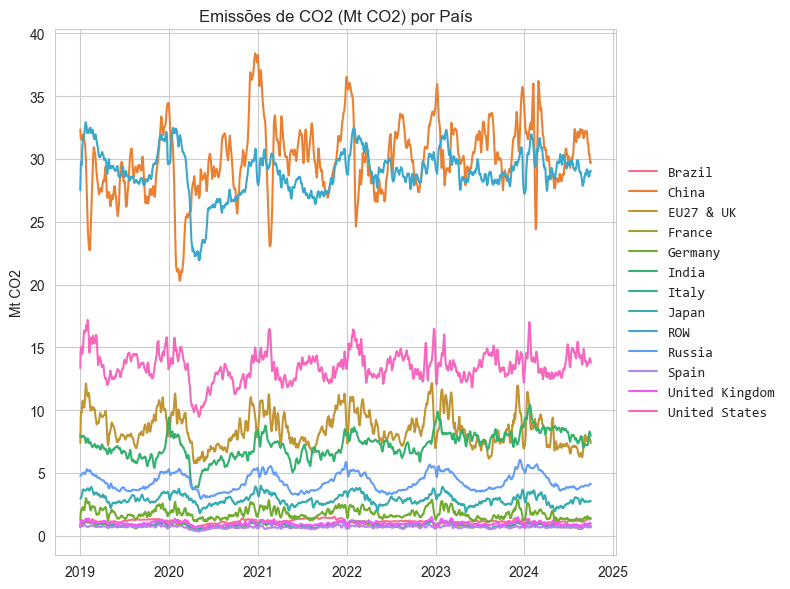

In [7]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.lineplot(
    data=dfQ1,
    y="rollingMtCO2",
    x="Date",
    hue="Country",
)

# Posicionando e customizando a legenda do gráfico
sns.move_legend(
    ax,
    "center left",
    bbox_to_anchor=(1, 0.5), # verticalmente no meio; para a direita do gráfico
    title=None,
    frameon=False,
    prop={"family": "consolas"}
)

plt.title("Emissões de CO2 (Mt CO2) por País")
plt.xlabel("")
plt.ylabel("Mt CO2")
plt.tight_layout()
plt.show()

### 2. Médias Móveis e Visibilidade nos gráficos
Visualizando diferenças entre Médias Móveis para melhorar a legibilidade dos Gráficos de linha

- Definindo funções para auxiliar na renderização da figura

In [8]:
def Q2_processarMediaMovel(df: pd.DataFrame, janela=0):
    return (
        df
        .groupby(["Country", "Sector"], as_index=False)
        ["MtCO2"]
        .rolling(janela, min_periods=1)
        .mean()
        ["MtCO2"]
    )

def Q2_renderizarChart(df: pd.DataFrame, ax: plt.Axes, title: str, janela: int):
    if janela > 1:
        df = df.assign(MtCO2=Q2_processarMediaMovel(df, janela))
    g = sns.lineplot(
        data = df,
        y="MtCO2",
        x="Date",
        hue="Sector",
        legend="full",
        ax=ax,
    )
    ax.set_title(title)
    # Escondendo os labels e ticks, os valores não são importantes aqui, somente a visibilidade das linhas
    ax.set_xlabel(''), ax.set_xlim(df["Date"].min())
    ax.set_ylabel(''), ax.set_ylim(0), ax.set_yticks([])
    return g

- Selecionando dados somente sobre o Brasil

In [9]:
dfQ2 = dfDailyEmissionsPerSector.groupby("Country").get_group("Brazil")

#### Figura
- Mostrando múltiplos gráficos de linhas, variando o tamanho da janela da média móvel.

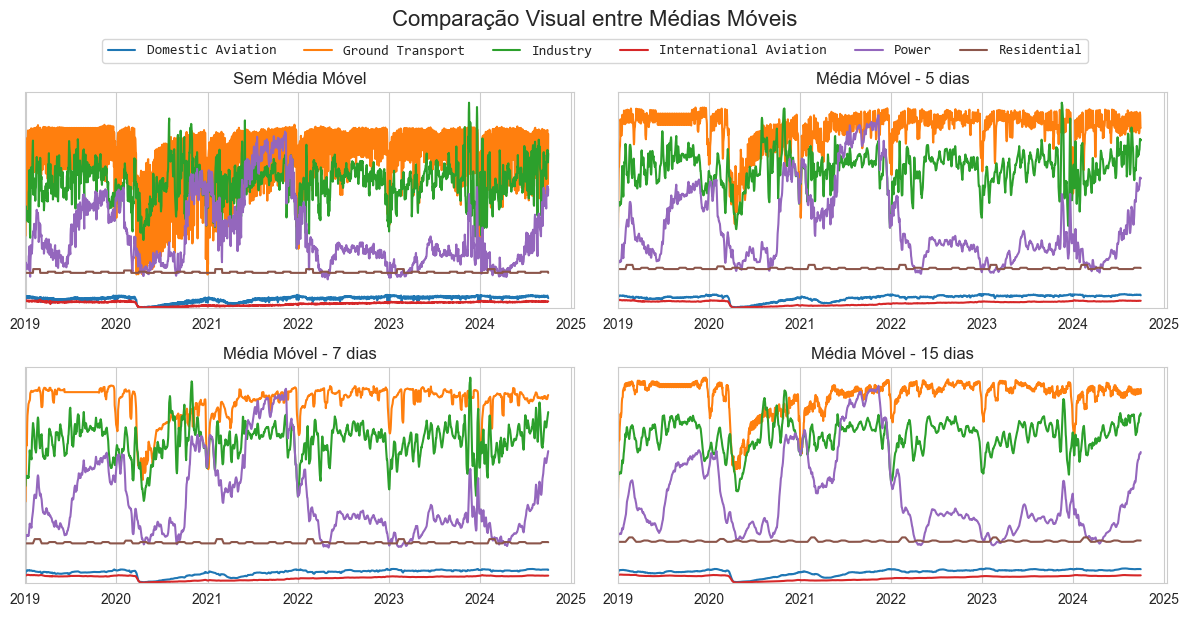

In [10]:
# Fazendo uma figura com subplots em 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes: List[List[plt.Axes]] # Explicitando o Type de `axes` para fazer o IntelliSense funcionar corretamente :/

# Plot 1 - Sem Média Móvel
Q2_renderizarChart(dfQ2, axes[0][0], "Sem Média Móvel", 0)
# Plot 2 - 5 Dias de Média Móvel
Q2_renderizarChart(dfQ2, axes[0][1], "Média Móvel - 5 dias", 5)
# Plot 3 - 7 Dias de Média Móvel
Q2_renderizarChart(dfQ2, axes[1][0], "Média Móvel - 7 dias", 7)
# Plot 4 - 15 Dias de Média Móvel
Q2_renderizarChart(dfQ2, axes[1][1], "Média Móvel - 15 dias", 15)

# Extraindo as handles e labels da legenda gerados pelo Seaborn
handles, labels = axes[0][0].get_legend_handles_labels()

# Removendo as legendas de todos os sub-plots, elas só serviam para fazer o passo acima :)
for ax in axes.flat:
    ax.legend_.remove()

# Manualmente renderizando uma legenda nova no topo da figura inteira
fig.legend(
    handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.92), ncol=6, frameon=True, prop={"family": "consolas"}
)

plt.suptitle("Comparação Visual entre Médias Móveis", 
               x=0.5, y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Limpando variáveis
del fig, axes, handles, labels, ax

- Entre a Média de 5 para a Média de 7, a linha de "Ground Transport" é dramaticamente suavizada, sugerindo que há variação nas emissões deste setor, seguindo um período de 7 dias
- A Média Móvel de 7 dias parece ter a melhor troca entre legibilidade e perda de dados
- Bonus: Se sobrar tempo, considerar fazer isso também: https://seaborn.pydata.org/examples/timeseries_facets.html

### 3. Evolução de Emissões por País e Setor
Visualizando histórico de Emissões por Setor em <u>escala normalizada</u>, para comparação relativa entre tendências e picos

- Selecionando somente 4 países para comparação lado a lado
- Fazendo média móvel por 30 dias das emissões de cada setor para melhorar a legibilidade dos gráficos

In [11]:
Q3_usarPaises = [
    "Brazil",  "United States",
    "France",  "China",
]

dfQ3 = (dfDailyEmissionsPerSector
    # Filtrando somente países selecionados
    [dfDailyEmissionsPerSector["Country"].isin(Q3_usarPaises)]

    # Fazendo média móvel por 30 dias das emissões de cada setor para melhorar a legibilidade do gráfico
    .assign(rollingMtCO2 = dfDailyEmissionsPerSector
            .groupby(["Country", "Sector"], as_index=False)["MtCO2"].rolling(30, min_periods=1).mean()["MtCO2"]
    )
)
dfQ3

Country       Date                  Sector     MtCO2  \
0              Brazil 2019-01-01       Domestic Aviation  0.023750   
1              Brazil 2019-01-01        Ground Transport  0.201663   
2              Brazil 2019-01-01                Industry  0.240156   
3              Brazil 2019-01-01  International Aviation  0.018398   
4              Brazil 2019-01-01                   Power  0.107727   
...               ...        ...                     ...       ...   
176389  United States 2024-09-30        Ground Transport  4.716510   
176390  United States 2024-09-30                Industry  2.577250   
176391  United States 2024-09-30  International Aviation  0.203197   
176392  United States 2024-09-30                   Power  4.271040   
176393  United States 2024-09-30             Residential  0.962485   

        rollingMtCO2  
0           0.023750  
1           0.201663  
2           0.240156  
3           0.018398  
4           0.107727  
...              ...  
176389      4.553647  
176390      2.856086  
176391      0.209775  
176392      4.733138  
176393      0.951353  

[50400 rows x 5 columns]

#### Figura
- Mostrando gráficos de linhas com Emissões de cada Setor, entre os 4 países selecionados
- Obs: Note que cada gráfico está em escalas diferentes para melhor visualizar e comparar as variações de cada país

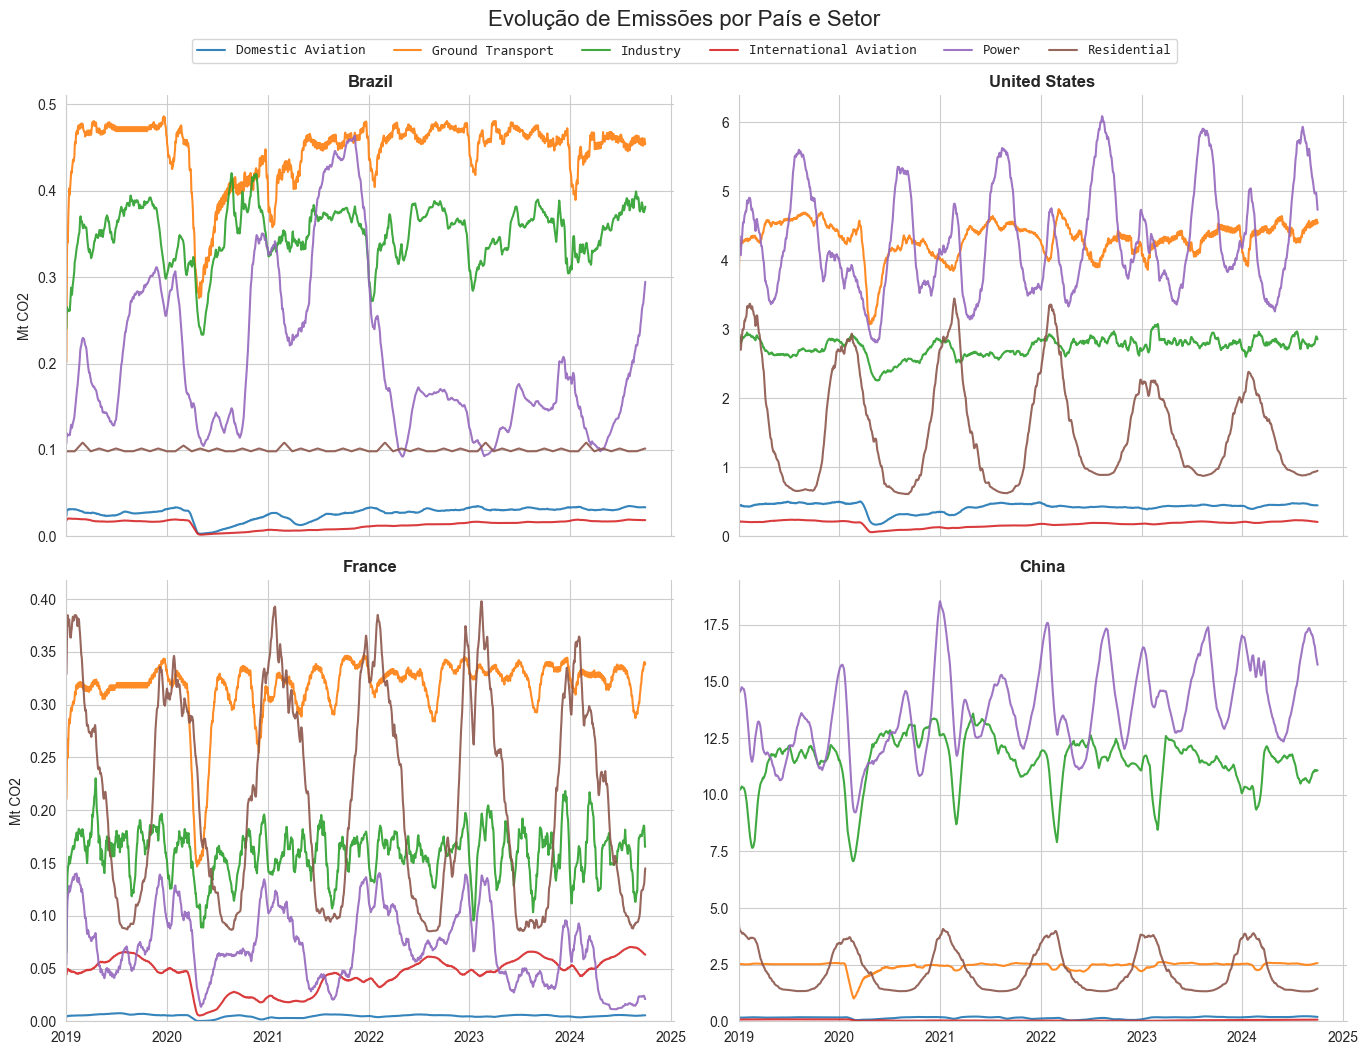

In [12]:
sns.set_style("whitegrid")
g = sns.relplot(
    kind="line",
    data=dfQ3,
    x="Date",
    y="rollingMtCO2", # Experimente mudar esse valor para "MtCO2" e veja como os gráficos ficam ilegíveis sem a média móvel :)
    col="Country",
    hue="Sector",
    alpha=0.9,
    facet_kws={
        "sharey": False,
    },
    col_wrap=2,
    col_order=Q3_usarPaises,
    aspect=1.2,
)

# Colocando legenda no topo da figura
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(0.5, 0.99),
    ncol=6, title=None, frameon=True,
    prop={"family": "consolas"}
)

for pais, ax in g.axes_dict.items():
    ax.set_title(pais, fontdict={"fontweight":"bold"})
    ax.set_xlim(dfQ3["Date"].min())
    ax.set_ylim(0)

g.set_axis_labels("", "Mt CO2")

g.figure.tight_layout()
g.figure.suptitle("Evolução de Emissões por País e Setor", 
               x=0.5, y=1.05, fontsize=16)

plt.show()
# Limpando variáveis
del g, pais, ax

- Para todos os países, há uma notável queda nos setores de transporte durante 2020, provavelmente devido à pandemia
- O setor residencial da França e Estados Unidos sobe muito durante o inverno, o da China sobe menos, e o do Brasil está praticamente imóvel.
    - Será que é porque não usamos ar condicionado/aquecedores em casa?
- O setor de indústria da China cai bastante depois do ano novo, será que alinha com o ano novo chinês?

#### 3.1? Pegar gráfico da China e desenhar linhas em cada ano novo chinês

### 4. Como o Brasil se posiciona em relação às emissões totais de gases de efeito estufa (GEE) em comparação ao total global?

- Usando dados agregados entre todos os Setores de cada País
- Descartando dados de entidades agrupadas: WORLD, ROW (Rest of World), EU27 & UK

In [13]:
dfQ4 = dfDailyEmissionsAggregate[~dfDailyEmissionsAggregate["Country"].isin(["WORLD", "ROW", "EU27 & UK"])]
dfQ4

Country       Date      MtCO2
0             Brazil 2019-01-01   0.690146
1             Brazil 2019-01-02   0.903277
2             Brazil 2019-01-03   0.966163
3             Brazil 2019-01-04   0.951562
4             Brazil 2019-01-05   0.905974
...              ...        ...        ...
27295  United States 2024-09-26  14.325019
27296  United States 2024-09-27  14.110585
27297  United States 2024-09-28  13.206505
27298  United States 2024-09-29  12.190760
27299  United States 2024-09-30  13.165790

[23100 rows x 3 columns]

Mostrando gráfico de barras, ordenado pelos países com a maior média de emissões

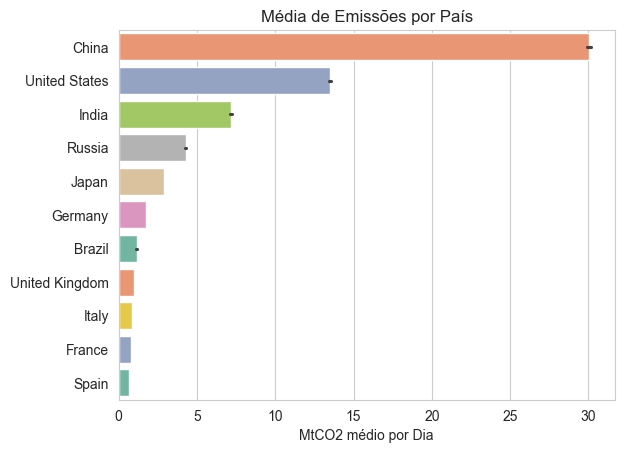

In [14]:
sns.barplot(
    data=dfQ4,
    y="Country",
    x="MtCO2",
    hue="Country",
    order=dfQ4.groupby("Country").mean().sort_values(by="MtCO2", ascending=False).index,
    palette="Set2"
)

plt.title("Média de Emissões por País")
plt.xlabel("MtCO2 médio por Dia")
plt.ylabel("")
plt.show()

### 5. Distribuição de Emissão por Setor por País

- Usando dados de todos os Setores de cada País
- Agregando média entre todos os pontos para cada Setor de cada País
- Ordenando Países por maior total de emissões
- Normalizando emissões de cada Setor para mostrar uma porcentagem relativa ao total de cada País

In [15]:
dfQ5 = (
    dfDailyEmissionsPerSector
    # Remova o comentário desta linha para descartar entidades que não são países de verdade :)
    # [~dfDailyEmissionsPerSector["Country"].isin(["WORLD", "ROW", "EU27 & UK"])]

    # Agregando média entre todos os setores e transformando em uma pivot table
    .pivot_table(index="Country", columns="Sector", values="MtCO2", aggfunc="mean")

    # Ordenando países por maior total de emissões
    .loc[lambda df: df.sum(axis=1).sort_values(ascending=False).index]
    
    # Normalizando as emissões de cada setor para uma porcentagem relativa ao total de seu país
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0) * 100)
)
dfQ5

Sector          Domestic Aviation  Ground Transport   Industry  \
Country                                                          
WORLD                    0.926579         18.166264  30.971655   
China                    0.518563          8.130392  38.118603   
ROW                      0.568487         20.790287  34.533446   
United States            3.147733         31.980249  20.291470   
EU27 & UK                0.436391         28.363496  20.457707   
India                    0.232495         10.803892  28.988549   
Russia                   1.060036         14.695306  19.533153   
Japan                    0.787900         16.796212  23.836042   
Germany                  0.201955         23.401985  18.219251   
Brazil                   2.332537         39.012571  30.651470   
United Kingdom           0.485024         32.130885  17.350329   
Italy                    0.539926         28.511164  16.763290   
France                   0.620428         39.290720  19.707290   
Spain                    2.115580         34.137564  24.339780   

Sector          International Aviation      Power  Residential  
Country                                                         
WORLD                         1.362837  38.759508     9.813157  
China                         0.154793  45.810272     7.267377  
ROW                           2.010456  32.767964     9.329360  
United States                 1.330890  31.871270    11.378389  
EU27 & UK                     4.832133  26.346511    19.563761  
India                         0.377204  52.265566     7.332294  
Russia                        0.463133  53.335576    10.912796  
Japan                         1.229139  47.266756    10.083951  
Germany                       3.480901  33.803243    20.892665  
Brazil                        1.175402  18.084289     8.743731  
United Kingdom                7.678882  17.963352    24.391528  
Italy                         3.543641  27.468733    23.173245  
France                        5.536068   8.668869    26.176625  
Spain                         7.678192  17.369440    14.359444

(Admito que 80% do código nessa célula é magia do GPT)
- Renderizando um gráfico de Barras empilhadas para cada País e seus Setores
- Renderizando texto dentro de cada barra com o valor percentual de cada Setor
    - Valores baixos demais para caber em sua barra não serão mostrados

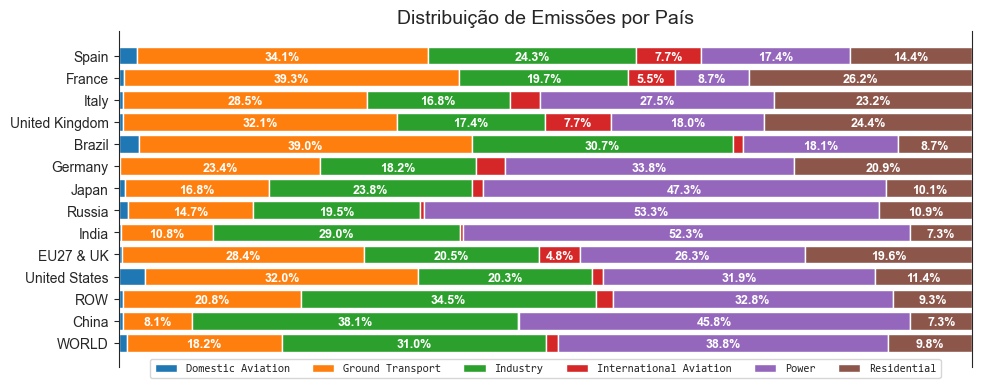

In [16]:
# Plot normalized stacked bar chart
sns.set_style("ticks")
plt.figure(figsize=(10, 4))

bottom = [0] * len(dfQ5)  # Initialize bottom positions for each country
for energyType in dfQ5.columns:
    # Render segment
    plt.barh(
        dfQ5.index,
        dfQ5[energyType],
        left=bottom, 
        label=energyType
    )

    # Add text inside each segment
    for i, value in enumerate(dfQ5[energyType]):
        # Somente mostrar valores grandes o suficiente para caber no seu segmento
        if value > 4:
            plt.text(
                bottom[i] + value / 2,  # Middle of the current segment
                i-0.075,  # Corresponding country index, fine-tuned by 0.075
                f"{value:.1f}%",  # Format percentage
                ha="center", 
                va="center",
                fontsize=9,
                fontweight="bold",
                color="white",
            )
    # Update the bottom positions for stacking
    bottom = [b + v for b, v in zip(bottom, dfQ5[energyType])]

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.04),
    ncol=6, title=None, frameon=True,
    # TODO: experimentar usar fonte Consolas aqui
    prop={"family": "consolas", "size": 8}
)

# Customize plot
sns.despine(bottom=True, right=False)
plt.title("Distribuição de Emissões por País", fontsize=14)
plt.xlabel(""), plt.xticks([]), plt.xlim(0, 100)
plt.ylabel("")
plt.tight_layout()
# Show plot
plt.show()

# Limpando variáveis
del bottom, i, value, energyType

### 6. Distribuição de Fontes de Energia por Setor por País

In [17]:
dfQ6 = (
    dfDailyPowerPerSector
    # Remova o comentário desta linha para descartar entidades que não são países de verdade :)
    # [~dfDailyPowerPerSector["Country"].isin(["WORLD", "ROW", "EU27 & UK"])]

    # Agregando média entre todos os setores e transformando em uma pivot table
    .pivot_table(index="Country", columns="Type", values="GWh/d", aggfunc="mean")

    # Ordenando países por maior total de emissões
    .loc[lambda df: df.sum(axis=1).sort_values(ascending=False).index]
    
    # Normalizando as emissões de cada setor para uma porcentagem relativa ao total de seu país
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0) * 100)
)
dfQ6

Type                 Coal        Gas  Hydroelectricity    Nuclear       Oil  \
Country                                                                       
China           58.771126   3.223897         15.975704   4.714808  0.115190   
United States   20.146409  38.537446          6.667944  19.722693  0.484516   
EU27 & UK       13.559334  18.289035         13.162818  25.138644  0.709642   
India           73.012871   2.184552         10.752369   2.873667  0.168801   
Russia          16.813748  44.248400         17.514457  19.819983  0.652017   
Japan           31.537789  37.336314          7.735960   7.123633  3.834981   
Brazil           8.120948   0.505928         68.200808   2.477574  2.774557   
France           0.106837   6.457796         13.879164  67.637234  0.292305   
Germany         27.683595  10.268577          6.592269   8.932972  0.685078   
Mexico           4.264573  62.699700          8.349092   3.397904  9.385522   
Turkey          36.862590  23.452864         23.436733   0.000000  0.201525   
Spain            2.214151  24.525041         13.645048  21.923551  0.484852   
Italy            7.674289  43.989412         18.019709   0.000000  0.499182   
United Kingdom   1.710772  41.173898          1.733334  18.597166  0.000035   
Australia       58.807581   8.901947          7.021722   0.000000  0.026158   
South Africa    83.849234   0.001857          2.968438   4.997850  1.025890   
Chile           27.154509  17.980548         26.235053   0.000000  1.017443   

Type            Other sources      Solar       Wind  
Country                                              
China                4.005196   5.236642   7.957437  
United States        1.845810   2.994894   9.600287  
EU27 & UK            6.811077   6.252971  16.076479  
India                2.033354   4.336199   4.638187  
Russia               0.513989   0.188452   0.248954  
Japan                2.107968   9.283123   1.040231  
Brazil               1.618509   3.737830  12.563847  
France               0.926579   3.380263   7.319821  
Germany              9.957101  10.593196  25.287212  
Mexico               1.334590   4.626661   5.941956  
Turkey               5.428920   0.762196   9.855172  
Spain                2.765987  11.812551  22.628818  
Italy               12.199112   9.212334   8.405962  
United Kingdom       7.928645   5.356321  23.499829  
Australia            0.106205  13.585460  11.550926  
South Africa         0.080188   2.859872   4.216670  
Chile                2.967835  15.030544   9.614067

- Definindo uma palheta de cores escolhida manualmente para representar cada fonte de Energia
    - ps. Energia Nuclear não tem nada a ver com a cor Verde mas todo mundo acha o contrário :'(

In [18]:
powerTypePalette = {
    "Coal": "#C51617", # Vermelho
    "Gas": "#EE6E0D",  # Laranja
    "Oil": "#9467BD",  # Roxo
    "Nuclear": "#2CA02C", # Verde
    "Hydroelectricity": "#1F77B4", # Azul Escuro
    "Solar": "#EEB10B", # Amarelo Escuro / Ouro
    "Wind": "#1FAEFF", # Azul Claro
    "Other sources": "#8C564B", # Marrom
}

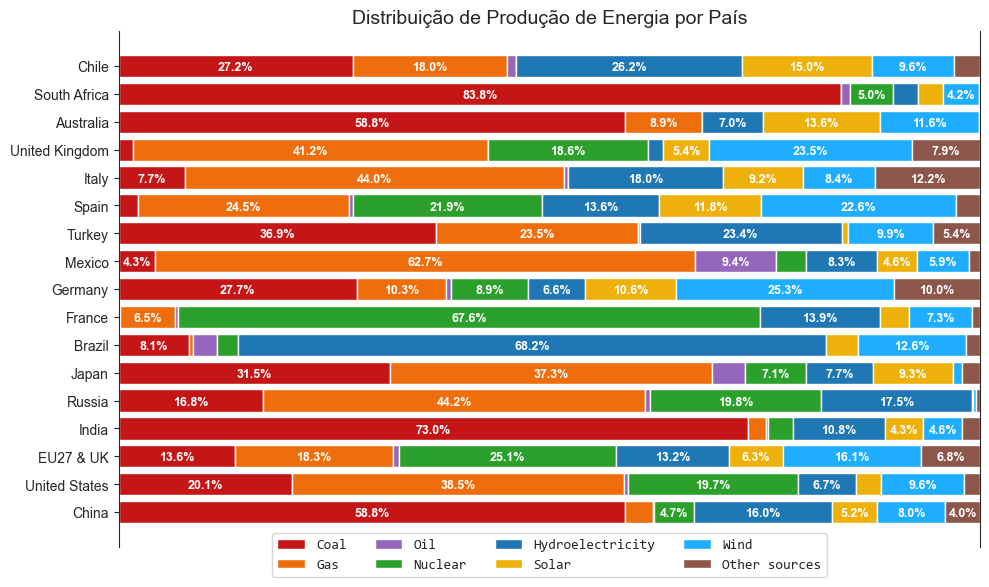

In [19]:
# Plot normalized stacked bar chart
sns.set_style("ticks")
plt.figure(figsize=(10, 6))

bottom = [0] * len(dfQ6)  # Initialize bottom positions for each country
for energyType in powerTypePalette.keys():
    # Render segment
    plt.barh(
        dfQ6.index,
        dfQ6[energyType],
        left=bottom, 
        label=energyType,
        color=powerTypePalette.get(energyType, "#333333")
    )

    # Add text inside each segment
    for i, value in enumerate(dfQ6[energyType]):
        # Somente mostrar valores grandes o suficiente para caber no seu segmento
        if value > 4:
            plt.text(
                bottom[i] + value / 2,  # Middle of the current segment
                i-0.045,  # Corresponding country index, fine-tuned by 0.075
                f"{value:.1f}%",  # Format percentage
                ha="center", 
                va="center",
                fontsize=9,
                fontweight="bold",
                color="white",
            )
    # Update the bottom positions for stacking
    bottom = [b + v for b, v in zip(bottom, dfQ6[energyType])]

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.04),
    ncol=4, title=None, frameon=True,
    prop={"family": "consolas"}
)

# Customize plot
sns.despine(bottom=True, right=False)
plt.title("Distribuição de Produção de Energia por País", fontsize=14)
plt.xlabel(""), plt.xticks([]), plt.xlim(0, 100)
plt.ylabel("")
plt.tight_layout()
# Show plot
plt.show()

# Limpando variáveis
del bottom, i, value, energyType

### 7. ?

### 8. ?

### 9. Usar AI para tentar prever um país pelo seu padrão de emissões? (normalizar valores para não ficar óbvio)

### 10. Usar AI com regression para tentar prever o dataset até 2025?

In [20]:
# Filter the data for a single country and sector as an example
country_example = "Brazil"
sector_example = "Ground Transport"

# Extract relevant data
example_data = dfDailyEmissionsPerSector[(dfDailyEmissionsPerSector['Country'] == country_example) & (dfDailyEmissionsPerSector['Sector'] == sector_example)].copy()

# Sort data by Date to ensure proper time series order
example_data = example_data.sort_values('Date')

# Display the prepared subset
example_data.head(), example_data['Date'].max()

(    Country       Date            Sector     MtCO2
 1    Brazil 2019-01-01  Ground Transport  0.201663
 85   Brazil 2019-01-02  Ground Transport  0.341199
 169  Brazil 2019-01-03  Ground Transport  0.418676
 253  Brazil 2019-01-04  Ground Transport  0.443308
 337  Brazil 2019-01-05  Ground Transport  0.371087,
 Timestamp('2024-09-30 00:00:00'))

In [21]:
def create_lag_features(df, value_col, lags, weekly_lags=None):
    """
    Create lag features for both daily and weekly patterns.
    
    Parameters:
    - df: DataFrame sorted by time.
    - value_col: Column name containing the target values.
    - lags: Number of daily lag features to create.
    - weekly_lags: List of weekly lag offsets to include.
    
    Returns:
    - DataFrame with lag features.
    """
    df = df.copy()
    # Daily lags
    for lag in range(1, lags + 1):
        df[f'Lag_{lag}'] = df[value_col].shift(lag)
    # Weekly lags
    if weekly_lags:
        for lag in weekly_lags:
            df[f'Lag_{lag}'] = df[value_col].shift(lag)
    return df

In [22]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # Define features and target
# features = [col for col in example_data_with_lags.columns if 'Lag' in col or 'Day_of_Week' in col]
# target = 'MtCO2'

# X = example_data_with_lags[features]
# y = example_data_with_lags[target]

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the model
# model = RandomForestRegressor(random_state=42)
# model.fit(X_train, y_train)

# # Evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")


In [23]:
# # Initialize future predictions with the last available data
# future_dates = pd.date_range(start='2024-10-01', end='2025-12-31')
# future_df = pd.DataFrame({'Date': future_dates})

# # Add placeholder columns for lags
# for col in features:
#     future_df[col] = np.nan

# # Predict step-by-step
# for i, row in future_df.iterrows():
#     # Prepare the features for prediction
#     row_features = pd.DataFrame([future_df.loc[i, features].ffill()], columns=features)
#     row_features = row_features.infer_objects(copy=False)  # Ensure numeric data types
    
#     # Predict the value
#     predicted_value = model.predict(row_features)[0]
    
#     # Add prediction to the dataframe
#     future_df.loc[i, 'MtCO2'] = predicted_value
    
#     # Update lag features for the next iteration
#     for lag in range(1, lags + 1):
#         if i + lag < len(future_df):
#             future_df.loc[i + lag, f'Lag_{lag}'] = predicted_value


In [26]:
from sklearn.ensemble import GradientBoostingRegressor


def forecast_sector_improved(data: pd.DataFrame, country, sector, lags, future_start, future_end):
    sector_data = data[(data['Country'] == country) & (data['Sector'] == sector)].copy()
    sector_data = sector_data.sort_values('Date')

    # Create lag features
    sector_data = create_lag_features(sector_data, 'MtCO2', lags, weekly_lags=[7, 14])
    sector_data['Day_of_Week'] = sector_data['Date'].dt.dayofweek
    sector_data['Rolling_Mean'] = sector_data['MtCO2'].rolling(window=7).mean()  # Example rolling mean
    sector_data = sector_data.dropna()

    # Define features and target
    features = [col for col in sector_data.columns if 'Lag' in col or 'Day_of_Week' in col or 'Rolling_Mean' in col]
    target = 'MtCO2'
    X = sector_data[features]
    y = sector_data[target]

    # Train the model
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X, y)

    # Prepare future DataFrame
    future_dates = pd.date_range(start=future_start, end=future_end)
    future_df = pd.DataFrame({'Date': future_dates})
    for col in features:
        future_df[col] = np.nan

    # Predict step-by-step
    for i, row in future_df.iterrows():
        row_features = pd.DataFrame([future_df.loc[i, features].ffill().infer_objects(copy=False)], columns=features)
        predicted_value = model.predict(row_features)[0]
        future_df.loc[i, 'MtCO2'] = predicted_value
        for lag in range(1, lags + 1):
            if i + lag < len(future_df):
                future_df.loc[i + lag, f'Lag_{lag}'] = predicted_value

    future_df['Sector'] = sector
    future_df['Country'] = country
    return future_df[['Date', 'Sector', 'Country', 'MtCO2']]


In [43]:
def forecast_sector_fixed(data, country, sector, lags, future_start, future_end):
    # Filter and sort the sector data
    sector_data = data[(data['Country'] == country) & (data['Sector'] == sector)].copy()
    sector_data = sector_data.sort_values('Date')

    # Create lag features
    sector_data = create_lag_features(sector_data, 'MtCO2', lags, weekly_lags=[7, 14])
    sector_data['Day_of_Week'] = sector_data['Date'].dt.dayofweek
    sector_data['Rolling_Mean'] = sector_data['MtCO2'].rolling(window=7).mean()

    # Handle missing values in historical data
    sector_data.ffill(inplace=True)  # Forward-fill NaNs
    sector_data.fillna(0, inplace=True)  # Replace any remaining NaNs with 0

    # Define features and target
    features = [col for col in sector_data.columns if 'Lag' in col or 'Day_of_Week' in col or 'Rolling_Mean' in col]
    target = 'MtCO2'
    X = sector_data[features]
    y = sector_data[target]

    # Train the model
    model = GradientBoostingRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.01,
        random_state=42
        )
    model.fit(X, y)

    # Prepare future DataFrame
    future_dates = pd.date_range(start=future_start, end=future_end)
    future_df = pd.DataFrame({'Date': future_dates})

    # Initialize lag features with the last known values from historical data
    last_row = sector_data.iloc[-1]
    for lag in range(1, lags + 1):
        future_df[f'Lag_{lag}'] = last_row[f'Lag_{lag}']
    future_df['Lag_7'] = last_row['Lag_7']
    future_df['Lag_14'] = last_row['Lag_14']
    future_df['Rolling_Mean'] = last_row['Rolling_Mean']
    future_df['Day_of_Week'] = future_df['Date'].dt.dayofweek

    # Predict step-by-step
    for i, row in future_df.iterrows():
        # Prepare features for the model
        row_features = pd.DataFrame([future_df.loc[i, features]], columns=features)
        predicted_value = model.predict(row_features)[0]

        # Store the predicted value
        future_df.loc[i, 'MtCO2'] = predicted_value

        # Update lag features for the next predictions
        if i + 1 < len(future_df):
            for lag in range(1, lags + 1):
                if i + lag < len(future_df):
                    future_df.loc[i + lag, f'Lag_{lag}'] = predicted_value

            # Update Rolling_Mean with available values
            available_values = future_df.loc[:i, 'MtCO2'].tail(7)
            future_df.loc[i + 1, 'Rolling_Mean'] = available_values.mean()

    # Add sector and country information
    future_df['Sector'] = sector
    future_df['Country'] = country
    return future_df[['Date', 'Sector', 'Country', 'MtCO2']]


In [44]:
# Forecast for all sectors for a given country
country = "Brazil"
sectors = dfDailyEmissionsPerSector[dfDailyEmissionsPerSector['Country'] == country]['Sector'].unique()
future_start = '2024-10-01'
future_end = '2025-12-31'

# Collect forecast results for all sectors
all_forecasts = []
for sector in sectors:
    forecast = forecast_sector_fixed(dfDailyEmissionsPerSector, country, sector, lags=3, future_start=future_start, future_end=future_end)
    all_forecasts.append(forecast)

# Combine all forecasts into a single DataFrame
all_forecasts_df = pd.concat(all_forecasts)
all_forecasts_df

Date             Sector Country     MtCO2
0   2024-10-01  Domestic Aviation  Brazil  0.031655
1   2024-10-02  Domestic Aviation  Brazil  0.030957
2   2024-10-03  Domestic Aviation  Brazil  0.031101
3   2024-10-04  Domestic Aviation  Brazil  0.032178
4   2024-10-05  Domestic Aviation  Brazil  0.030187
..         ...                ...     ...       ...
452 2025-12-27        Residential  Brazil  0.098464
453 2025-12-28        Residential  Brazil  0.098464
454 2025-12-29        Residential  Brazil  0.098464
455 2025-12-30        Residential  Brazil  0.098464
456 2025-12-31        Residential  Brazil  0.098464

[2742 rows x 4 columns]

In [45]:
# Combine historical and forecasted data
combined_data = pd.concat([dfDailyEmissionsPerSector[dfDailyEmissionsPerSector['Country'] == country][['Date', 'Sector', 'Country', 'MtCO2']], all_forecasts_df], ignore_index=True)
combined_data

Date                  Sector Country     MtCO2
0     2019-01-01       Domestic Aviation  Brazil  0.023750
1     2019-01-01        Ground Transport  Brazil  0.201663
2     2019-01-01                Industry  Brazil  0.240156
3     2019-01-01  International Aviation  Brazil  0.018398
4     2019-01-01                   Power  Brazil  0.107727
...          ...                     ...     ...       ...
15337 2025-12-27             Residential  Brazil  0.098464
15338 2025-12-28             Residential  Brazil  0.098464
15339 2025-12-29             Residential  Brazil  0.098464
15340 2025-12-30             Residential  Brazil  0.098464
15341 2025-12-31             Residential  Brazil  0.098464

[15342 rows x 4 columns]

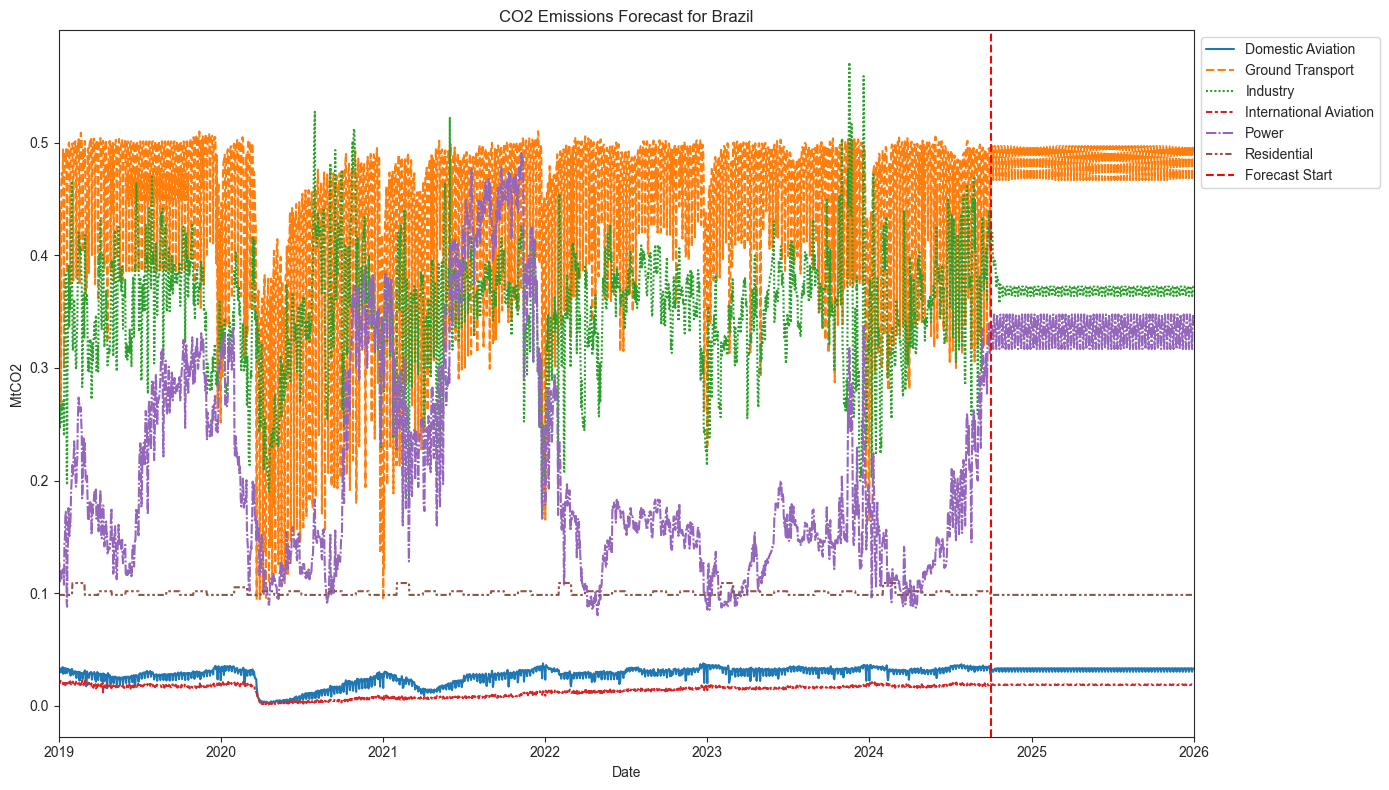

In [46]:

# Plot with better differentiation
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_data, x='Date', y='MtCO2', hue='Sector', style='Sector', markers=False)
plt.xlim(pd.to_datetime('2019'), pd.to_datetime('2026'))
plt.axvline(x=pd.to_datetime('2024-09-30'), color='red', linestyle='--', label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('MtCO2')
plt.title(f'CO2 Emissions Forecast for {country}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
